# Step Count From Video

### Overview
Count the number of steps from a carefully controlled treadmill video. We identify a unique color in a region of interest (ROI), such as a shoelace. This color is tracked and the number of zero crossing (normalized) is correlated to a step. Specifically create an object around the the color of interest and track the trajectory in Euclidean space (x,y). Zero crossings are estimated by identifing the zero slope and inflection point of the y coordinate time series.

### Improvements
- <font color='red'>Automate ROI (DONE)</font> 
- Physically place unique color tags (neon stickers) on shoes during test-
- Automate start and stop frames
- Consider contours in Visualization
- Test accuracy over various test scenarios
- Consider transforming to HSV space to mitigate shadows
- Automate setting of kernel size (for object detect) and mask threshold
- Use history to track trajectory
- <font color='red'>Minimum stride rate (DONE)</font>

### Imports and System Parameters

In [1]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib osx
print('Using OpenCV version %s'%cv2.__version__)
print('Using Numpy version  %s'%np.__version__)
ver = sys.version.split('|')
print('Using python verion  %s'%ver[0])
print('('+ver[1]+')')
print(ver[2])

# system parameters
# Display tracking Video and Debug Messages
#DISP = True
DISP = True

# size of kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8,8))

# min blob size
minBlobArea = 5

# +/- in RGB color space
offset = 20

# file to interrogate
filename = './Downloads/StepCountRateVideos/20161110_152638 KeDe Step Count.mp4'

# frame window over which actual steps are taken
startFrame = 500
endFrame = 25700

Using OpenCV version 3.1.0
Using Numpy version  1.11.1
Using python verion  3.5.2 
(Anaconda 4.2.0 (x86_64))
 (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


### Function Definitions

In [2]:
def onclick(event):
    print('button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          (event.button, event.x, event.y, event.xdata, event.ydata))
    global idxList
    idxList.append([event.xdata, event.ydata])
#    global axRef
#    axRef.scatter(int(event.xdata), int(event.ydata))
    
def getPoint(x,y,img):
    temp = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return temp[x,y]

def getLineSegment(x1,x2,y,img):
    temp = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return temp[x1:x2,y]

def colorFromIdx(idx, frame):
    x,y = idx 
    return frame[int(y), int(x), :]

def plotMask(idx, frame, offset):
    idColor = colorFromIdx(idx, frame)
    mask = np.zeros(frame.shape)
    for ii,color in enumerate(idColor):
        mask[:,:,ii] = (frame[:,:,ii] > color-offset) & (frame[:,:,ii]<color+offset)

    plt.figure()
    plt.imshow(np.sum(mask,axis=2))
    plt.title(str(idx))

def plotRefPoint(idx, ax):
    x,y = idx 
    ax.scatter(int(x), int(y))
    
def getMask(idColor, frame, offset):
    mask = np.zeros(frame.shape)
    for ii,color in enumerate(idColor):
        mask[:,:,ii] = (frame[:,:,ii] > color-offset) & (frame[:,:,ii]<color+offset) 
    mask = np.sum(mask, axis=2) ==3
    return mask

def getBlob(mask):
    blob = cv2.dilate(mask.astype(np.uint8), kernel)
    return blob

def getCentroid(blob):
    temp = blob.copy()
    temp[temp==0] = 255
    temp[temp==1] = 0
    keypoints = detector.detect(temp)
#    keypoints = detector.detect(blob)
    return keypoints


# Set up the SimpleBlobdetector with default parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0;
params.maxThreshold = 256;

# Filter by Area.
params.filterByArea = True
params.minArea = minBlobArea

# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.5

# Filter by Inertia
params.filterByInertia = False
params.minInertiaRatio = 0.5

detector = cv2.SimpleBlobDetector_create(params)

def trackSteps(idx, roiRef, DISP, filename, roiPoints):
    
    x,y = idx
    r,c,h,w = roiPoints 
    idColor = colorFromIdx(idx, roiRef)
    xBuff = [x]
    yBuff = [y]
    frameSkip = 0

    cap = cv2.VideoCapture(filename)
    cap.set(cv2.CAP_PROP_POS_FRAMES,frameSkip)
    ret,frame = cap.read()
    count = frameSkip

    while ret:
        count = count + 1
        roi = frame[r:h,c:w]

        mask = getMask(idColor, roi, offset)
        blob = getBlob(mask)
        keypoints = getCentroid(blob)

        # if we find any blobs
        if keypoints:

            # assume one and use that as the centroid
            x,y = keypoints[0].pt

            # if more than one find the one closest to the last one
            minVal = float('inf')
            for kp in keypoints:
                x,y = kp.pt
                dist = np.power((x-xBuff[-1]),2)+np.power((y-yBuff[-1]),2)
                if dist < minVal:
                    minVal = dist
                    xOut = x
                    yout = y


        else:

            # if no blob found then use the old value
            # mostly we get here because the blob touches the edge of the image
            x = xBuff[-1]
            y = yBuff[-1]
            #input('')

        xBuff.append(x)
        yBuff.append(y)
           
        if DISP and (count%1000 == 0):
            print(count)

        if DISP:

            fr,fc,t = frame.shape
            frameMask = np.ones([fr,fc],dtype=np.uint8)      
            frameMask[r:h,c:w] = cv2.bitwise_xor(blob,1)        
            new = cv2.circle(cv2.bitwise_and(frame, frame, mask=frameMask), (int(x)+c,int(y)+r), 5, 255, -1)
            cv2.imshow('frame',new)

    #         if cv2.waitKey(1) & 0xFF == ord('q'):
    #             break

            k = cv2.waitKey(0)
            if k == 27:         # wait for ESC key to exit
                cv2.destroyAllWindows()
                break
            elif k == ord('n'): # wait for 's' for next frame
                t = 1

        ret,frame = cap.read()


    cap.release()
    return [xBuff, yBuff]

def trackPoints(filename, frameOffset, roiPoints):
    r,h,c,w = roiPoints 

    # grab and display a frame during run
    cap = cv2.VideoCapture(filename)
    cap.set(cv2.CAP_PROP_POS_FRAMES,frameOffset)
    fs = cap.get(cv2.CAP_PROP_FPS)

    ret,frame = cap.read()
    # set up the ROI for tracking
    roiRef = frame[r:r+h, c:c+w]
           
    cv2.namedWindow('select track points')
    cv2.setMouseCallback('select track points',draw_circle)

    while(1):
        cv2.imshow('image',roiRef)
        k = cv2.waitKey(1) & 0xFF
        if k == ord('m'):
            mode = not mode
        elif k == 27:
            break

    cv2.destroyAllWindows()

 
    # mouse click on columns to histogram
    return [roiRef, fs]

def countSteps(yBuff, startFrame, endFrame):
    # user input to figure out true offset
    threshStepSamples = 4 #min number of sample per stride based on max step rate

    # low pass filter to smooth
    N=10
    fc = fs/600.

    import scipy.signal as sp

    # use firwin with arbitrary Fs
    h=sp.firwin( numtaps=N, cutoff=fc, nyq=fs/2)
    filtY=sp.lfilter( h, 1.0, yBuff) # 'x' is the time-series data you are filtering


    # count number of positive inflextions points (first derivative zero / second neg)
    dy = np.diff(filtY)
    dy[dy>0] = 1
    dy[dy<0] = -1
    ddy = np.diff(dy)

    # this counts just one legg steps
    #ddy[ddy>0] = 0

    # if we assume a backswing == a forward swing with the other leg
    stepsToCount = ddy[startFrame:endFrame]
    totalSteps = np.count_nonzero(stepsToCount)
    print('Total Steps before minimum correction = %d'%totalSteps)

    A = np.diff(np.nonzero(stepsToCount))[0]
    newTotalSteps = len(A[A>threshStepSamples])
    print('Total Steps after minimum correction = %d'%newTotalSteps)
    return [filtY, dy, ddy, A]    

   

### Manually select unique color pixel to track in ROI

In [3]:
idxList = []
roiList = []

def draw_circle(event,x,y,flags,param):
    global idxList
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(roiScale,(x,y),3,(255,0,0),-1)
        idxList.append([x,y])

def draw_roi(event,x,y,flags,param):
    global roiList
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(frame,(x,y),3,(255,0,0),-1)
        print(x,y)
        roiList.append([x,y])     
        
        
# automate this with user input based on time maybe
frameOffset = 0

        
# grab and display a frame during run
cap = cv2.VideoCapture(filename)
cap.set(cv2.CAP_PROP_POS_FRAMES,frameOffset)
fs = cap.get(cv2.CAP_PROP_FPS)

ret,frame = cap.read()

cv2.namedWindow('select roi')
cv2.setMouseCallback('select roi',draw_roi)
while(1):
    cv2.imshow('select roi', frame)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows() 

        
c,r = roiList[0]
w,h = roiList[1]
roiPoints = (r,c,h,w)

# set up the ROI for tracking
roi = frame[r:h,c:w]

cv2.namedWindow('select track points')
cv2.setMouseCallback('select track points',draw_circle)
roiScale = cv2.resize(roi, None,fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
roiPristine = roiScale.copy()

while(1):
    cv2.imshow('select track points', roiScale)
    k = cv2.waitKey(1) & 0xFF
    if k == ord('m'):
        mode = not mode
    elif k == 27:
        break

cv2.destroyAllWindows() 



True

299 296
477 467


### Visualize selected Points

In [4]:
for idx in idxList:    
    plotMask(idx, roiPristine, offset)

### Process (track, filter, and count)

In [5]:
selectedIdx = int(input('Select Optimal Color to Track '))  


[xBuff, yBuff] = trackSteps(idxList[selectedIdx], roiPristine, True, filename, roiPoints)

#[smooth, slope, inflection, steps] =  countSteps(yBuff, fs, startFrame, endFrame)

Select Optimal Color to Track 1


Total Steps before minimum correction = 1980
Total Steps after minimum correction = 1923
Total Steps before minimum correction = 1982
Total Steps after minimum correction = 1921
Total Steps before minimum correction = 1982
Total Steps after minimum correction = 1921
Total Steps before minimum correction = 1981
Total Steps after minimum correction = 1923
Total Steps before minimum correction = 0
Total Steps after minimum correction = 0
Total Steps before minimum correction = 0
Total Steps after minimum correction = 0
Total Steps before minimum correction = 0
Total Steps after minimum correction = 0


(array([  13.,    0.,    0.,   16.,    0.,    0.,    7.,    0.,    0.,
           0.,   20.,    0.,    0.,   24.,    0.,    0.,   21.,    0.,
           0.,    0.,   19.,    0.,    0.,   16.,    0.,    0.,   86.,
           0.,    0.,    0.,  361.,    0.,    0.,  426.,    0.,    0.,
         255.,    0.,    0.,    0.,  167.,    0.,    0.,   86.,    0.,
           0.,   52.,    0.,    0.,    0.,   42.,    0.,    0.,   40.,
           0.,    0.,   97.,    0.,    0.,    0.,   55.,    0.,    0.,
          72.,    0.,    0.,   33.,    0.,    0.,    0.,    3.,    0.,
           0.,    2.,    0.,    0.,    0.,    0.,    0.,    0.,    4.,
           0.,    0.,    3.,    0.,    0.,   12.,    0.,    0.,    0.,
          21.,    0.,    0.,   18.,    0.,    0.,    6.,    0.,    0.,    2.]),
 array([  1. ,   1.3,   1.6,   1.9,   2.2,   2.5,   2.8,   3.1,   3.4,
          3.7,   4. ,   4.3,   4.6,   4.9,   5.2,   5.5,   5.8,   6.1,
          6.4,   6.7,   7. ,   7.3,   7.6,   7.9,   8.2,   8.5,   8.

(array([  12.,    0.,    0.,   20.,    0.,    0.,   12.,    0.,    0.,
           0.,   16.,    0.,    0.,   21.,    0.,    0.,    0.,   22.,
           0.,    0.,   16.,    0.,    0.,    0.,   22.,    0.,    0.,
          69.,    0.,    0.,    0.,  371.,    0.,    0.,  415.,    0.,
           0.,  268.,    0.,    0.,    0.,  183.,    0.,    0.,   75.,
           0.,    0.,    0.,   50.,    0.,    0.,   37.,    0.,    0.,
           0.,   57.,    0.,    0.,   90.,    0.,    0.,    0.,   41.,
           0.,    0.,   74.,    0.,    0.,   39.,    0.,    0.,    0.,
           4.,    0.,    0.,    1.,    0.,    0.,    0.,    3.,    0.,
           0.,    1.,    0.,    0.,    0.,    7.,    0.,    0.,    9.,
           0.,    0.,    0.,   19.,    0.,    0.,   21.,    0.,    0.,    6.]),
 array([  1.  ,   1.29,   1.58,   1.87,   2.16,   2.45,   2.74,   3.03,
          3.32,   3.61,   3.9 ,   4.19,   4.48,   4.77,   5.06,   5.35,
          5.64,   5.93,   6.22,   6.51,   6.8 ,   7.09,   7.38,   

(array([  13.,    0.,    0.,   19.,    0.,    0.,   12.,    0.,    0.,
           0.,   16.,    0.,    0.,   21.,    0.,    0.,    0.,   23.,
           0.,    0.,   17.,    0.,    0.,    0.,   22.,    0.,    0.,
          72.,    0.,    0.,    0.,  370.,    0.,    0.,  412.,    0.,
           0.,  266.,    0.,    0.,    0.,  188.,    0.,    0.,   72.,
           0.,    0.,    0.,   48.,    0.,    0.,   36.,    0.,    0.,
           0.,   58.,    0.,    0.,   90.,    0.,    0.,    0.,   38.,
           0.,    0.,   74.,    0.,    0.,   42.,    0.,    0.,    0.,
           4.,    0.,    0.,    1.,    0.,    0.,    0.,    3.,    0.,
           0.,    1.,    0.,    0.,    0.,    7.,    0.,    0.,    9.,
           0.,    0.,    0.,   20.,    0.,    0.,   21.,    0.,    0.,    6.]),
 array([  1.  ,   1.29,   1.58,   1.87,   2.16,   2.45,   2.74,   3.03,
          3.32,   3.61,   3.9 ,   4.19,   4.48,   4.77,   5.06,   5.35,
          5.64,   5.93,   6.22,   6.51,   6.8 ,   7.09,   7.38,   

(array([  17.,    0.,    0.,   13.,    0.,    0.,   20.,    0.,    0.,
           0.,    7.,    0.,    0.,   10.,    0.,    0.,   16.,    0.,
           0.,    0.,   10.,    0.,    0.,   20.,    0.,    0.,  109.,
           0.,    0.,    0.,  324.,    0.,    0.,  443.,    0.,    0.,
         308.,    0.,    0.,    0.,  117.,    0.,    0.,   94.,    0.,
           0.,   50.,    0.,    0.,    0.,   66.,    0.,    0.,   47.,
           0.,    0.,   87.,    0.,    0.,    0.,   62.,    0.,    0.,
          63.,    0.,    0.,   19.,    0.,    0.,    0.,   11.,    0.,
           0.,    4.,    0.,    0.,    6.,    0.,    0.,    0.,    8.,
           0.,    0.,   10.,    0.,    0.,   20.,    0.,    0.,    0.,
          14.,    0.,    0.,    3.,    0.,    0.,    1.,    0.,    0.,    1.]),
 array([  1. ,   1.3,   1.6,   1.9,   2.2,   2.5,   2.8,   3.1,   3.4,
          3.7,   4. ,   4.3,   4.6,   4.9,   5.2,   5.5,   5.8,   6.1,
          6.4,   6.7,   7. ,   7.3,   7.6,   7.9,   8.2,   8.5,   8.

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
         0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
         0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
         0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
         0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
         0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
         0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
         0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
         0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
         0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
         0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
         0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
         0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
         0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
         0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
         0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        

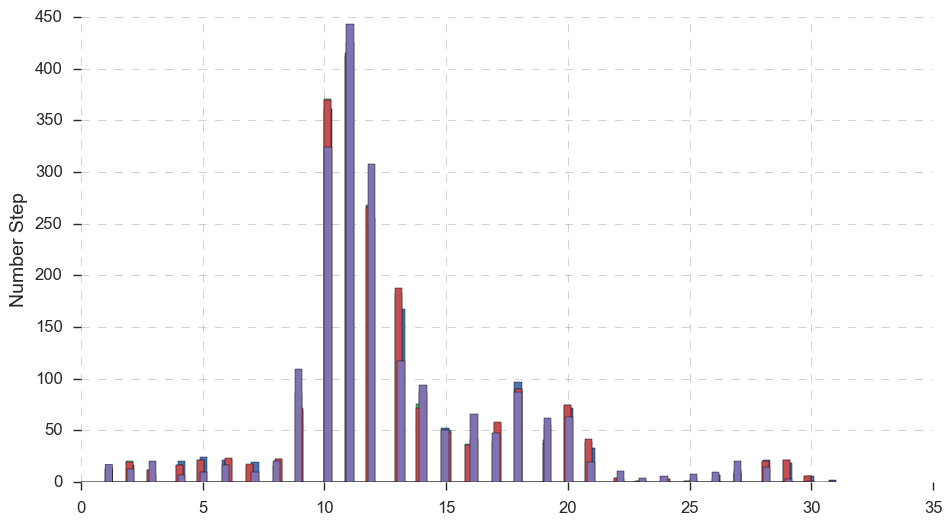

In [6]:
import pickle
S = pickle.load(open(filename[:-4]+'_buffFile.pkl', 'rb'))
superFilter = []

for buff in S:
    xBuff,yBuff = buff
    superFilter.append(countSteps(yBuff, startFrame, endFrame))

%run 'import_plots.ipynb'

sns.set_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(11, 6))

for filt in superFilter:
    smooth, slope, inflection, steprate = filt
    plt.hist(steprate, 100);

plt.ylabel('Number Step', fontsize=14)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(which='major', axis='x', labelsize=12)
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
sns.despine(trim=True, left=True, bottom=True)

#### Debug Code

In [ ]:
plt.figure()
# plt.plot(filtY)
#plt.plot(filtY[20000:])
plt.plot(filtY,'.-')



In [ ]:
%run 'import_plots.ipynb'

In [ ]:
ipplot(S[3][1])

In [ ]:
ipplot(ddy.tolist())

In [ ]:
ipplot(filtY.tolist())

In [ ]:
B = [len(A[A>thresh]) for thresh in np.arange(30)]
pplot(B);

In [ ]:
plt.hist(A,100);

In [ ]:
np.where(A==29)
A[1798]

In [ ]:
idx = np.nonzero(stepsToCount)[0]
idx[np.where(A==29)]

In [ ]:
fudge  = (len(xBuff)/fs) / 878.

In [ ]:
125/fs/fudge

In [ ]:
import pickle
S = pickle.load(open('buffFile', 'rb'))
